In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [ ]:

df_retail = pd.read_excel('../data/Online Retail.xlsx')
df_ecommerce = pd.read_csv('../data/data.csv', encoding='ISO-8859-1')


# Exploring the Datasets

In [ ]:
print(df_retail.info())
print('\n')
print(df_ecommerce.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  5

# Data Preproessing

In [ ]:
df_ecommerce.drop_duplicates(inplace=True)
df_retail.drop_duplicates(inplace=True)


df_ecommerce.dropna(inplace=True)
df_retail.dropna(inplace=True)

In [ ]:
columns = df_retail.select_dtypes(include=['float64','int64','object']).columns.tolist()
# print(columns)


df_ecom = df_ecommerce[columns]
df_ret = df_retail[columns]


df_concat = pd.concat([df_ecom, df_ret], axis = 0, ignore_index=True)

print(df_concat.head())
print(df_concat.tail())
print(df_concat.shape)


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

   UnitPrice  CustomerID         Country  
0       2.55     17850.0  United Kingdom  
1       3.39     17850.0  United Kingdom  
2       2.75     17850.0  United Kingdom  
3       3.39     17850.0  United Kingdom  
4       3.39     17850.0  United Kingdom  
       InvoiceNo StockCode                      Description  Quantity  \
803203    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
803204    581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
803205    581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
803206    581587 

#CONCATENATION OF THE TWO DATASETS

In [ ]:
df_select = df_concat[['Quantity','UnitPrice','Country']]


df_encoded = pd.get_dummies(df_select,columns=['Country'],dtype= int,drop_first=True)
print(df_encoded.head())

df_drop = df_select.drop(columns='Country')

print(df_drop.head())
total_columns = df_encoded.columns.tolist()


   Quantity  UnitPrice  Country_Austria  Country_Bahrain  Country_Belgium  \
0         6       2.55                0                0                0   
1         6       3.39                0                0                0   
2         8       2.75                0                0                0   
3         6       3.39                0                0                0   
4         6       3.39                0                0                0   

   Country_Brazil  Country_Canada  Country_Channel Islands  Country_Cyprus  \
0               0               0                        0               0   
1               0               0                        0               0   
2               0               0                        0               0   
3               0               0                        0               0   
4               0               0                        0               0   

   Country_Czech Republic  ...  Country_RSA  Country_Saudi Arabia  \

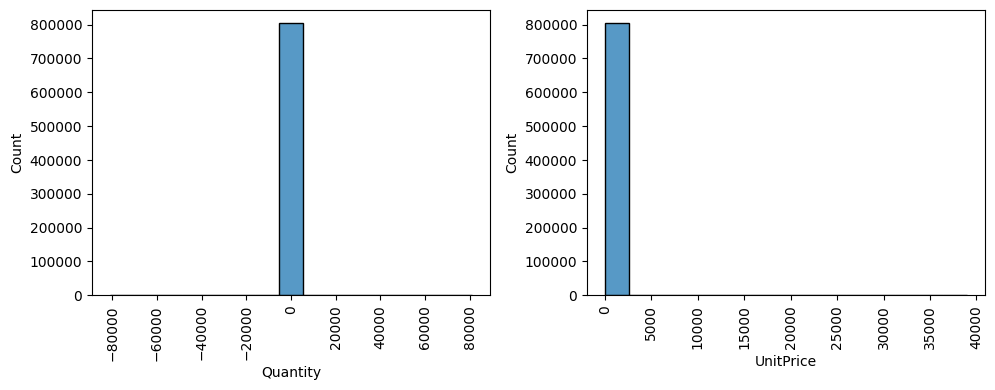

In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

df_num = df_drop.select_dtypes(include=['float64', 'int64'])
num_var = df_num.columns.tolist()
num_plots = len(num_var)
cols = 3
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(15, rows * 4))
for i, x in enumerate(num_var):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df_num[x], bins=15)
    plt.xticks(rotation=90)   # <-- rotate x-axis labels
plt.tight_layout()
plt.show()


# APPLYING STANDARD SCALER

In [ ]:

standard_scaler =  StandardScaler()
standard_scaler.fit(df_drop)

# transform data
df_num_scaled = standard_scaler.transform(df_drop)
print(df_num_scaled)

[[-0.02470515 -0.01324558]
 [-0.02470515 -0.00120497]
 [-0.01671419 -0.01037877]
 ...
 [-0.03269611  0.00968891]
 [-0.03269611  0.00968891]
 [-0.0366916   0.02115615]]


# converting the standardized dataset into a dataframe

In [ ]:

# df_sca= pd.DataFrame(df_num_scaled,columns=total_columns)
df_sca = df_encoded.copy()
print(df_sca.head())

   Quantity  UnitPrice  Country_Austria  Country_Bahrain  Country_Belgium  \
0         6       2.55                0                0                0   
1         6       3.39                0                0                0   
2         8       2.75                0                0                0   
3         6       3.39                0                0                0   
4         6       3.39                0                0                0   

   Country_Brazil  Country_Canada  Country_Channel Islands  Country_Cyprus  \
0               0               0                        0               0   
1               0               0                        0               0   
2               0               0                        0               0   
3               0               0                        0               0   
4               0               0                        0               0   

   Country_Czech Republic  ...  Country_RSA  Country_Saudi Arabia  \

# DETERMING THE OPOTIMAL NUMBER OF CLUSTERS

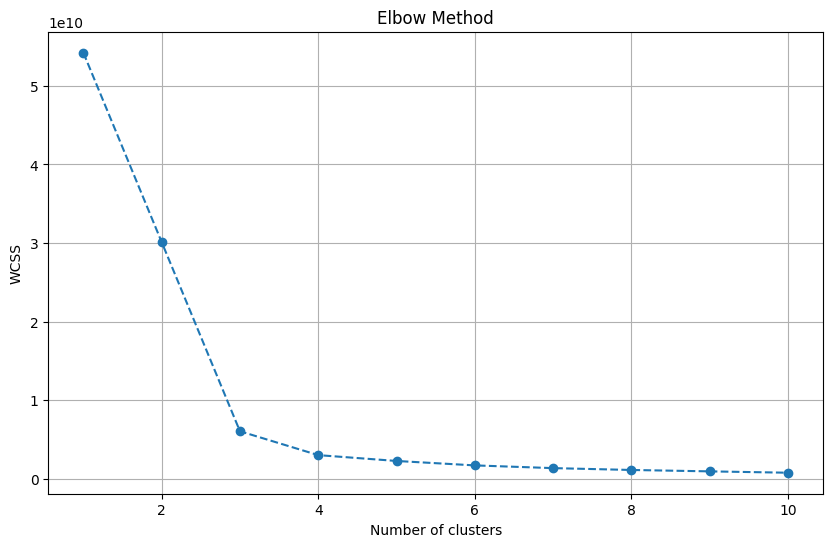

In [ ]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_sca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.savefig('elbow_method.png')
plt.show()

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Define clustering models inside a dictionary
clustering_models = {
    "KMeans": KMeans(n_clusters=5, random_state=42)

}

# Fit models and get cluster labels
results = {}

for name, model in clustering_models.items():
    # fit_predict returns cluster labels directly
    labels = model.fit_predict(df_sca)   # <-- X is your feature matrix (scaled is better!)

    results[name] = labels

    print(results)




{'KMeans': array([0, 0, 0, ..., 0, 0, 0], dtype=int32)}


In [ ]:
df_results =pd.DataFrame(results)
print(df_results.head())


df_fo = pd.DataFrame(df_num_scaled, columns=['Quantity',
            'UnitPrice'])

print(df_fo.head())


   KMeans
0       0
1       0
2       0
3       0
4       0
   Quantity  UnitPrice
0 -0.024705  -0.013246
1 -0.024705  -0.001205
2 -0.016714  -0.010379
3 -0.024705  -0.001205
4 -0.024705  -0.001205


# VISIUALIZING THE K-MEANS WITH PROFILE PLOT

   Quantity  UnitPrice  KMeans
0 -0.024705  -0.013246       0
1 -0.024705  -0.001205       0
2 -0.016714  -0.010379       0
3 -0.024705  -0.001205       0
4 -0.024705  -0.001205       0
          Quantity   UnitPrice
KMeans                        
0         0.000004   -0.004675
1      -310.118020   -0.027436
2       310.020664   -0.027436
3        -0.052674  558.548175
4        -0.049078   43.966180


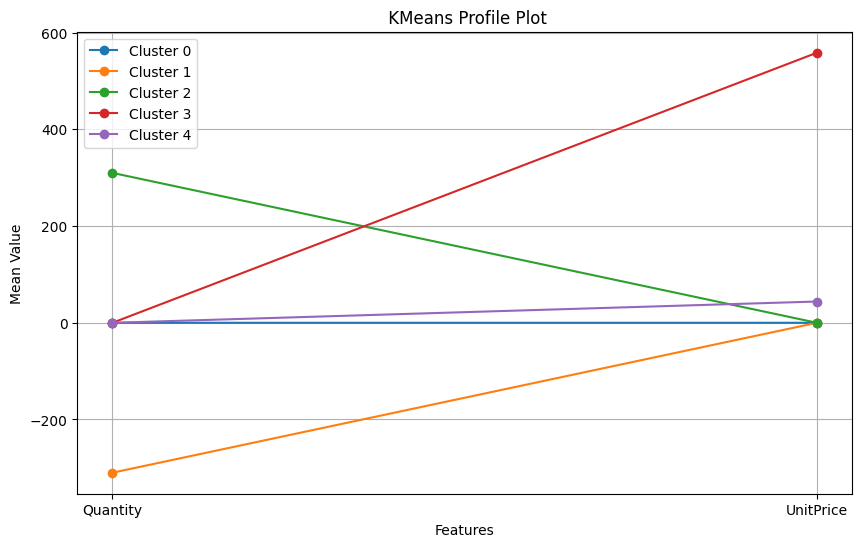

In [ ]:


df_cluster = pd.concat([df_fo, df_results], axis = 1)


print(df_cluster.head())

import matplotlib.pyplot as plt

# Assuming cluster_summary is now the mean values per cluster
df_summary = df_cluster.groupby('KMeans').agg({
            'Quantity':'mean',
            'UnitPrice':'mean'
})

print(df_summary.head())



import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for cluster in df_summary.index:
    plt.plot(df_summary.columns,
             df_summary.loc[cluster],
             marker='o',
             label=f'Cluster {cluster}')

plt.title(' KMeans Profile Plot')
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)  # Make x-axis labels horizontal
plt.legend()
plt.grid(True)
plt.show()

